In [9]:
import geopandas as gp
import pandas as pd
from collections import Counter
import contextily as cx
import os
import matplotlib.pyplot as plt

# Louisiana 2022 General Election Precinct Boundaries and Election Results 

Notes
- The source of the precinct shapefiles is this file: https://redist.legis.la.gov/default_ShapeFiles2020
- This file was created after the creation of the election results file, that file is used as an input

## Load in Files

In [10]:
election_results = pd.read_csv("./raw-from-source/la_2022_gen_prec.csv")
shapes = gp.read_file("./raw-from-source/2022_Louisiana_Precincts_(12-25-2022)/2022_Louisiana_Precincts_(12-25-2022).shp")

In [11]:
# Define a races list
races = ['G22A1NO',
 'G22A1YES',
 'G22A2NO',
 'G22A2YES',
 'G22A3NO',
 'G22A3YES',
 'G22A4NO',
 'G22A4YES',
 'G22A5NO',
 'G22A5YES',
 'G22A6NO',
 'G22A6YES',
 'G22A7NO',
 'G22A7YES',
 'G22A8NO',
 'G22A8YES',
 'G22USSDCHA',
 'G22USSDMEN',
 'G22USSDMIX',
 'G22USSDROD',
 'G22USSDSTE',
 'G22USSIMCM',
 'G22USSLSIG',
 'G22USSNBIL',
 'G22USSNOLS',
 'G22USSOJOH',
 'G22USSOWEN',
 'G22USSRGRA',
 'G22USSRKEN',
 'GCON01DDAR',
 'GCON01LKEA',
 'GCON01RSCA',
 'GCON02DCAR',
 'GCON02RLUX',
 'GCON03DLEB',
 'GCON03DOLI',
 'GCON03IWIG',
 'GCON03LMCL',
 'GCON03RHIG',
 'GCON03RHOG',
 'GCON03RPAY',
 'GCON03RSHA',
 'GCON05DDAN',
 'GCON05DHUF',
 'GCON05RGUI',
 'GCON05RLET',
 'GCON05RPUL',
 'GCON06LCRA',
 'GCON06RBEL',
 'GCON06RGRA',
 'SSU05DDUP',
 'SSU05DLAN',
 'SSU17DLAC',
 'SSU17RKLE',
 'SSU17RROU']

In [12]:
election_results_raw = election_results.copy(deep = True)

## Deal with Alpha Precincts

Note: In alpha precincts, votes are recorded separately by last name of voter, these splits are combined for this file.

In [13]:
# Load in a file RDH created that links the relevant alpha precincts together
sub_precinct_rolls = pd.read_csv("./raw-from-source/Supporting_Files/sub_precinct_rolls.csv")

sub_precinct_rolls_dict = dict(zip(sub_precinct_rolls["join_id"], sub_precinct_rolls["modified_prec"]))
sub_precinct_rolls_vtd_dict = dict(zip(sub_precinct_rolls["modified_prec"], sub_precinct_rolls["GEOID20"]))

# Note the Parishes using the alpha precincts
set(sub_precinct_rolls["join_id"].apply(lambda x: x.split("-:-")[0]))

{'Ascension',
 'Assumption',
 'Bossier',
 'Caddo',
 'East Baton Rouge',
 'Lafourche',
 'Rapides',
 'St. Charles',
 'Terrebonne'}

In [14]:
parish_fip_dict = dict(zip(election_results["Parish"], election_results["COUNTYFP"]))

In [15]:
fip_parish_dict = dict(zip(election_results["COUNTYFP"], election_results["Parish"]))

In [16]:
# Apply the changes and group the results to combine the alpha precincts
election_results["UNIQUE_ID"] = election_results["UNIQUE_ID"].map(sub_precinct_rolls_dict).fillna(election_results["UNIQUE_ID"])
election_results = election_results.groupby("UNIQUE_ID").sum()
election_results.reset_index(inplace = True, drop = False)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_24265/3199472239.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  election_results = election_results.groupby("UNIQUE_ID").sum()


In [17]:
# Add back in the relevant columns from above (step may not have been needed if a pivot table was used)
election_results["Parish"] = election_results["UNIQUE_ID"].apply(lambda x:x.split("-:-")[0])
election_results["Precinct"] = election_results["UNIQUE_ID"].apply(lambda x:x.split("-:-")[1])
election_results["COUNTYFP"] = election_results["Parish"].map(parish_fip_dict)

## Join Election Results to Precinct Boundaries

In [18]:
# This file links election result precinct IDs to those found in the shapefile
helper = pd.read_csv("./raw-from-source/Supporting_Files/correspondence_table.csv")
name_change_dict = dict(zip(helper["UNIQUE_ID"], helper["GEOID20"]))

# Apply the name changes
election_results["join_id"] = election_results["UNIQUE_ID"].map(name_change_dict).fillna(election_results["UNIQUE_ID"])
election_results["join_id"] = election_results["UNIQUE_ID"].map(sub_precinct_rolls_vtd_dict).fillna(election_results["join_id"])

# Attempt to join the files
join_attempt_one = gp.GeoDataFrame(pd.merge(election_results, shapes, how = "outer",left_on = "join_id", right_on = "GEOID20", indicator = True))

# Examine the results
print(join_attempt_one["_merge"].value_counts())

both          3777
right_only       7
left_only        0
Name: _merge, dtype: int64


## Clean Unjoined Precincts

Note: As shown below, all of these contain 0 registered voters, so not surprising that they aren't appearing in the election results. For the final file, we need to add a Parish assignment to these precincts.

In [19]:
join_attempt_one[join_attempt_one["_merge"]!="both"][["GEOID20","COUNTYFP20","VTDST20","TOT_POP","REG_TOTAL_"]]

,GEOID20,COUNTYFP20,VTDST20,TOT_POP,REG_TOTAL_
3777,22085003-7X,085,003-7X,22,0
3778,22105ZZZZZZ,105,ZZZZZZ,0,0
3779,22095ZZZZZZ,095,ZZZZZZ,0,0
3780,22089ZZZZZZ,089,ZZZZZZ,0,0
3781,22051ZZZZZZ,051,ZZZZZZ,0,0
3782,22103ZZZZZZ,103,ZZZZZZ,0,0
3783,22071ZZZZZZ,071,ZZZZZZ,0,0


In [20]:
join_attempt_one.loc[join_attempt_one["UNIQUE_ID"].isna(),"VTDST20"]

3777    003-7X
3778    ZZZZZZ
3779    ZZZZZZ
3780    ZZZZZZ
3781    ZZZZZZ
3782    ZZZZZZ
3783    ZZZZZZ
Name: VTDST20, dtype: object

In [21]:
parish_fip_dict = {value:key for key, value in fip_parish_dict.items()}

In [24]:
# Add the parish assignment
join_attempt_one[join_attempt_one["UNIQUE_ID"].isna()]["COUNTYFP20"].astype(int).map(fip_parish_dict)

3777                  Sabine
3778              Tangipahoa
3779    St. John The Baptist
3780             St. Charles
3781               Jefferson
3782             St. Tammany
3783                 Orleans
Name: COUNTYFP20, dtype: object

In [25]:
# Use the VTDST20, as part of the UNIQUE_ID for these precincts
join_attempt_one.loc[join_attempt_one["UNIQUE_ID"].isna(),"UNIQUE_ID"] = join_attempt_one[join_attempt_one["UNIQUE_ID"].isna()]["COUNTYFP20"].astype(int).map(fip_parish_dict)+"-:-"+join_attempt_one.loc[join_attempt_one["UNIQUE_ID"].isna(), "VTDST20"]
join_attempt_one["Parish"] = join_attempt_one["UNIQUE_ID"].apply(lambda x: x.split("-:-")[0])
join_attempt_one[join_attempt_one["_merge"]!="both"][["UNIQUE_ID","Parish","GEOID20","COUNTYFP20","VTDST20","TOT_POP","REG_TOTAL_"]]

,UNIQUE_ID,Parish,GEOID20,COUNTYFP20,VTDST20,TOT_POP,REG_TOTAL_
3777,Sabine-:-003-7X,Sabine,22085003-7X,085,003-7X,22,0
3778,Tangipahoa-:-ZZZZZZ,Tangipahoa,22105ZZZZZZ,105,ZZZZZZ,0,0
3779,St. John The Baptist-:-ZZZZZZ,St. John The Baptist,22095ZZZZZZ,095,ZZZZZZ,0,0
3780,St. Charles-:-ZZZZZZ,St. Charles,22089ZZZZZZ,089,ZZZZZZ,0,0
3781,Jefferson-:-ZZZZZZ,Jefferson,22051ZZZZZZ,051,ZZZZZZ,0,0
3782,St. Tammany-:-ZZZZZZ,St. Tammany,22103ZZZZZZ,103,ZZZZZZ,0,0
3783,Orleans-:-ZZZZZZ,Orleans,22071ZZZZZZ,071,ZZZZZZ,0,0


In [26]:
join_attempt_one["COUNTYFP"] = join_attempt_one["COUNTYFP20"]

In [27]:
join_attempt_one = join_attempt_one.fillna(0)
join_attempt_one.drop("_merge", inplace = True, axis = 1)

In [28]:
joined_pber = join_attempt_one.copy(deep = True)

# Check If There are Splits

In [29]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one
    
def get_level_dist(column_name):
    if column_name[0:4] == "GSLP":
        level = "SL"
        dist = "004"
    elif column_name[0:3] == "GSL":
        level = "SL"
        dist = column_name[3:6]
    elif column_name[0:3] == "SSU":
        level = "SU"
        dist = column_name[3:5]
    elif column_name[0:3] == "GCO":
        level = "CON"
        dist = column_name[4:6]
    else:
        print(column_name)
        raise ValueError
    return level,dist

def contains_sldl(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SL":
            return dist_tuple[1]
        
def contains_cong(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "CON":
            return dist_tuple[1]
        
def contains_sldu(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SU":
            return dist_tuple[1]

precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in joined_pber.iterrows():
    precinct_list = []
    for contest in races:
        if(row[contest]!=0) and ("GSL" in contest or "GCO" in contest or "SSU" in contest):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["UNIQUE_ID"]]=is_split
    precinct_mapping_dict[row["UNIQUE_ID"]]=precinct_list
    
cong_check_list = {i:contains_cong(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}
sldu_check_list = {i:contains_sldu(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

In [30]:
print(split_precincts_list)

{}


## Clean up N/A District Assignments

- Note: The race for Congressional District 4 was uncontested and as such there are no results and thus no district assignments for that district.The State Senate results in this election were special elections on the pre-redistricting boundaries for two seats, 5 and 17. All precincts without votes for these races have an "SLDL_DIST" value of "N/A".

In [31]:
def clean_na_dist_assignments(elections_gdf, district_gdf, unique_ID_col, elections_gdf_dist_ID, district_gdf_ID, ):
    
    if elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()].shape[0]==0:
        return elections_gdf
    
    original_crs = elections_gdf.crs
    elections_gdf = elections_gdf.to_crs(3857)
    
    district_gdf = district_gdf.to_crs(3857)
    
    dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID].isna()], district_gdf, how = "intersection")

    dist_clean['area'] = dist_clean.area

    na_assignment_dict = {}

    for val in dist_clean[unique_ID_col].unique():

        assignment = dist_clean.loc[dist_clean[unique_ID_col] == val].nlargest(1, 'area')[district_gdf_ID].values[0]
        na_assignment_dict[val] = assignment

    elections_gdf[elections_gdf_dist_ID] = elections_gdf[unique_ID_col].map(na_assignment_dict).fillna(elections_gdf[elections_gdf_dist_ID])    

    elections_gdf = elections_gdf.to_crs(original_crs)
    
    return elections_gdf

In [32]:
CONG_PATH = ""
SLDU_PATH = ""

Note: Loading in the 118th Congressional Districts and the pre-redistricting boundaries, as those are special elections

In [33]:
# Load in CONG and SLDU shapefiles
la_cong_districts = gp.read_file(CONG_PATH)
la_sldu_districts = gp.read_file(SLDU_PATH)

la_cong_districts = la_cong_districts.to_crs(joined_pber.crs)
la_sldu_districts = la_sldu_districts.to_crs(joined_pber.crs)

la_cong_districts = la_cong_districts[la_cong_districts["STATE"]=="LA"]
la_sldu_districts = la_sldu_districts[la_sldu_districts["STATE"]=="LA"]

joined_pber["CONG_DIST"] = joined_pber["UNIQUE_ID"].map(cong_check_list)
joined_pber["SLDU_DIST"] = joined_pber["UNIQUE_ID"].map(sldu_check_list)

# Clean na district assignments
joined_pber = clean_na_dist_assignments(joined_pber, la_cong_districts, "UNIQUE_ID", "CONG_DIST", "DISTRICT")

In [172]:
joined_pber["CONG_DIST"].value_counts(dropna = False)

05    842
04    831
02    599
03    554
01    535
06    423
Name: CONG_DIST, dtype: int64

## Compare Geometries

In [35]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 2 precincts for differences of greater than 0.1 km^2

1) For 17 difference in area is 10.54526908547999

Scroll down to see plots of any differences

Of the 2 precincts:

0 precincts w/ a difference of 0 km^2
1 precincts w/ a difference between 0 and .1 km^2
0 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
1 precincts w/ a difference greater than 5 km^2


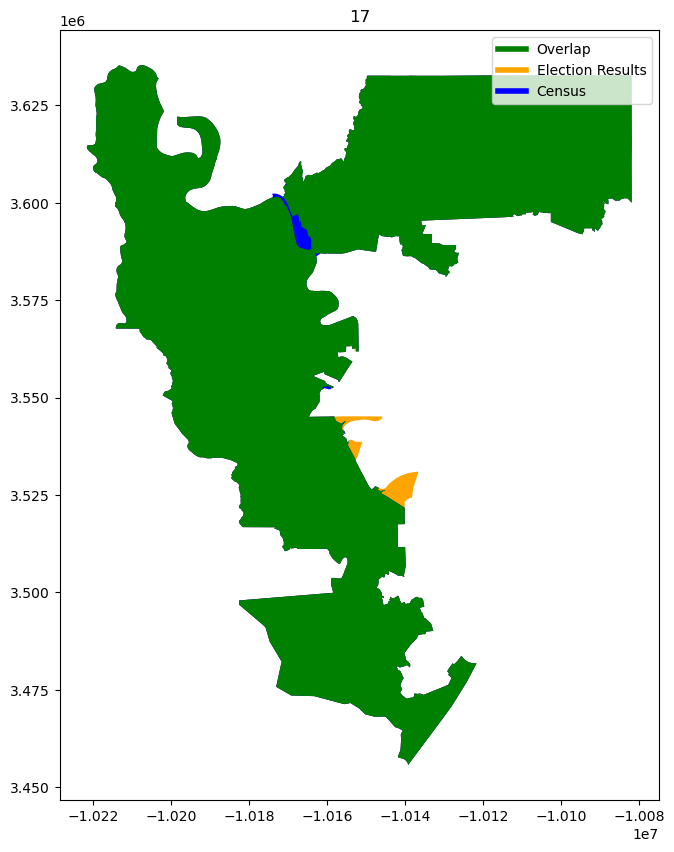

In [36]:
la_cong_districts.rename(columns = {"DISTRICT":"CONG_DIST"}, inplace = True)
la_sldu_districts.rename(columns = {"DISTRICT":"SLDU_DIST"}, inplace = True)

filtered_cong_results = joined_pber[~joined_pber["CONG_DIST"].isna()].dissolve("CONG_DIST")
filtered_cong_results.reset_index(inplace = True, drop = False)

filtered_sldu_results = joined_pber[~joined_pber["SLDU_DIST"].isna()].dissolve("SLDU_DIST")
filtered_sldu_results.reset_index(inplace = True, drop = False)

la_sldu_districts["SLDU_DIST"] = la_sldu_districts["SLDU_DIST"].astype(str).str.zfill(2)



In [ ]:
# Check implied SLDU districts based off of assignments against the actual ones
compare_geometries(filtered_sldu_results, la_sldu_districts[la_sldu_districts["SLDU_DIST"].isin(["05","17"])] ,"Election Results", "Census", "SLDU_DIST",area_threshold=.1)


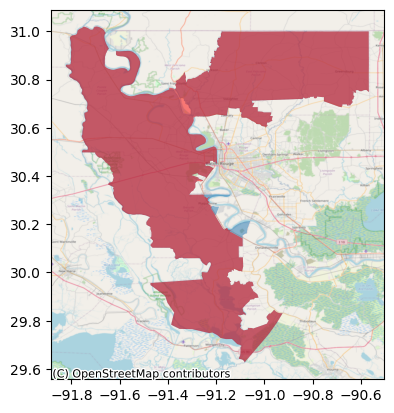

In [184]:
ax = filtered_sldu_results[filtered_sldu_results["SLDU_DIST"]=="17"].plot(alpha = .5)
la_sldu_districts[la_sldu_districts["SLDU_DIST"]=="17"].plot(ax = ax, color = "red", alpha = .5)
cx.add_basemap(ax = ax, crs = filtered_sldu_results.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Checking 6 precincts for differences of greater than 0.1 km^2

1) For 02 difference in area is 0.6305735590281677
2) For 06 difference in area is 0.630574701809949

Scroll down to see plots of any differences

Of the 6 precincts:

0 precincts w/ a difference of 0 km^2
4 precincts w/ a difference between 0 and .1 km^2
0 precincts w/ a difference between .1 and .5 km^2
2 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


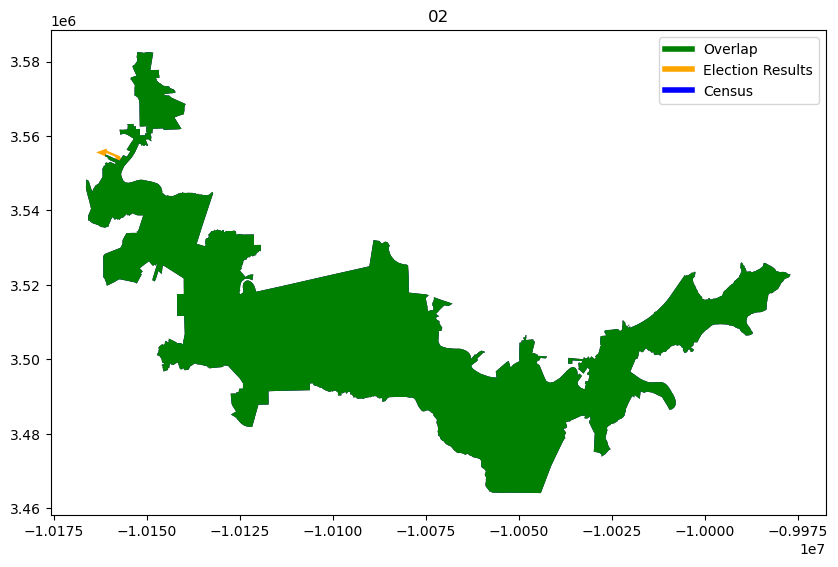

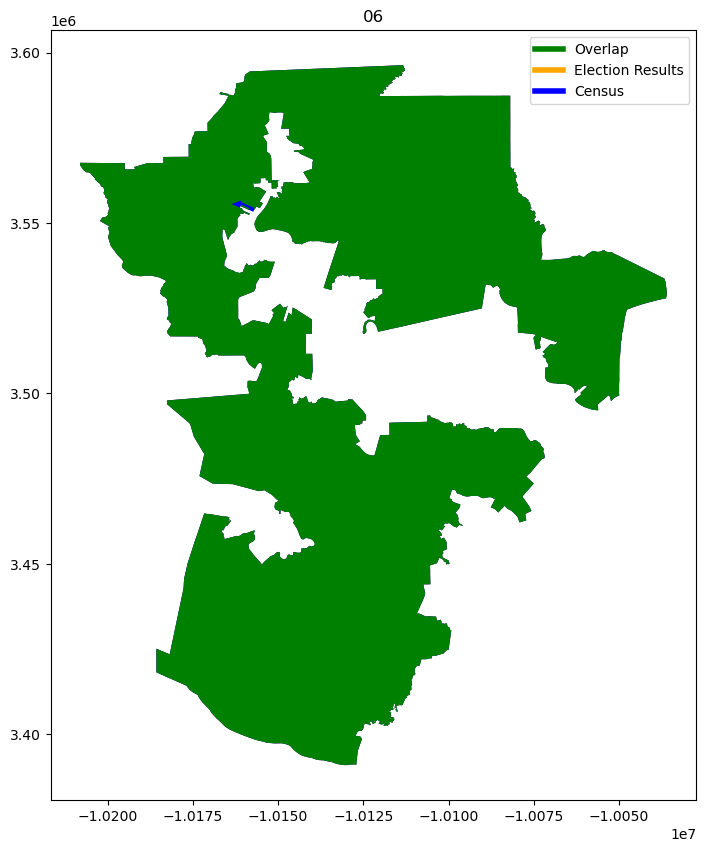

In [185]:
# Check implied CONG districts based off of assignments against the actual ones
compare_geometries(filtered_cong_results, la_cong_districts ,"Election Results", "Census", "CONG_DIST",area_threshold=.1)


(30.2, 30.5)

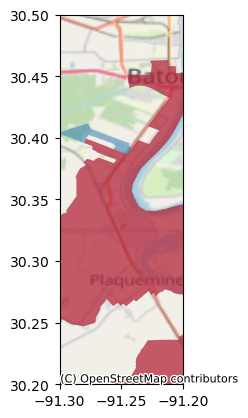

In [186]:
ax = filtered_cong_results[filtered_cong_results["CONG_DIST"]=="02"].plot(alpha = .5)
la_cong_districts[la_cong_districts["CONG_DIST"]=="02"].plot(ax = ax, color = "red", alpha = .5)
cx.add_basemap(ax = ax, crs = filtered_cong_results.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

ax.set_xlim([-91.3, -91.2])
ax.set_ylim(30.2, 30.5)

In [37]:
## Check Implied Parish Assignments

In [39]:
COUNTY_PATH = ""

In [40]:
la_counties = gp.read_file(COUNTY_PATH)
la_counties.rename(columns = {"COUNTYFP20":"COUNTYFP"}, inplace = True)
grouped_counties = joined_pber.dissolve("COUNTYFP")
grouped_counties.reset_index(inplace = True, drop = False)

In [192]:
compare_geometries(la_counties, grouped_counties, "Census", "File", "COUNTYFP")

Checking 64 precincts for differences of greater than 0.1 km^2


Scroll down to see plots of any differences

Of the 64 precincts:

0 precincts w/ a difference of 0 km^2
64 precincts w/ a difference between 0 and .1 km^2
0 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
0 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2


## File Quality Checks

Compare total vote data from the election results against the registered voters data in the precinct shapefile

In [42]:
joined_pber["TOT_VOTES"] = joined_pber["G22A1YES"] + joined_pber["G22A2YES"]
joined_pber["ratio"] = joined_pber["REG_TOTAL_"] / joined_pber["TOT_VOTES"]

lower_filter = joined_pber[(joined_pber["ratio"] > 0)&(joined_pber["ratio"] < .75)]
higher_filter = joined_pber[(joined_pber["ratio"] < 1000)&(joined_pber["ratio"] > 3.5)]


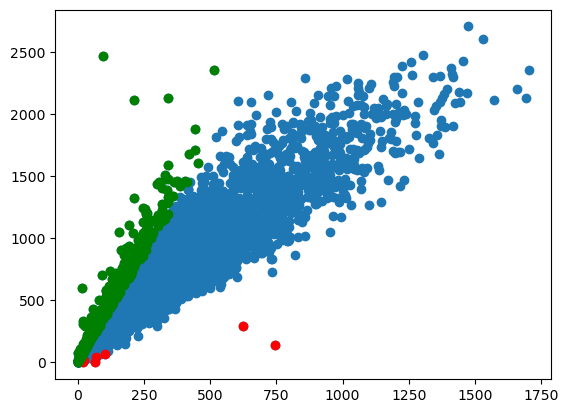

In [43]:
plt.scatter(joined_pber["TOT_VOTES"], joined_pber["REG_TOTAL_"])
plt.scatter(lower_filter["TOT_VOTES"], lower_filter["REG_TOTAL_"],color = "red")
plt.scatter(higher_filter["TOT_VOTES"], higher_filter["REG_TOTAL_"],color = "green")

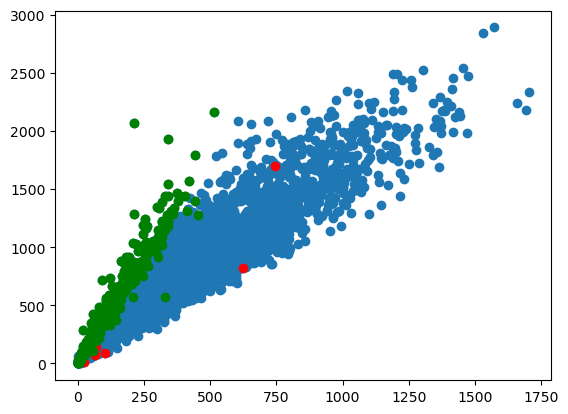

In [44]:
plt.scatter(joined_pber["TOT_VOTES"], joined_pber["REG_TOTA_1"])
plt.scatter(lower_filter["TOT_VOTES"], lower_filter["REG_TOTA_1"],color = "red")
plt.scatter(higher_filter["TOT_VOTES"], higher_filter["REG_TOTA_1"],color = "green")

In [45]:
lower_filter[lower_filter["TOT_VOTES"]>500]

,UNIQUE_ID,COUNTYFP,G22A1NO,G22A1YES,G22A2NO,G22A2YES,G22A3NO,G22A3YES,G22A4NO,G22A4YES,...,REG_OTH__6,REG_OTH__7,REG_OTH__8,SHAPE_AREA,SHAPE_LEN,geometry,CONG_DIST,SLDU_DIST,TOT_VOTES,ratio
373,Caddo-:-00 005B,017,398.0,276.0,195.0,469.0,300.0,363.0,148.0,524.0,...,50,324,32,0.000811,0.267074,"POLYGON ((-93.77975 32.55087, -93.77967 32.550...",None,None,745.0,0.189262
2558,Pointe Coupee-:-00 13,077,376.0,206.0,175.0,419.0,386.0,205.0,202.0,391.0,...,108,50,6,0.038984,1.193707,"POLYGON ((-91.75719 30.56682, -91.75664 30.568...",05,17,625.0,0.467200


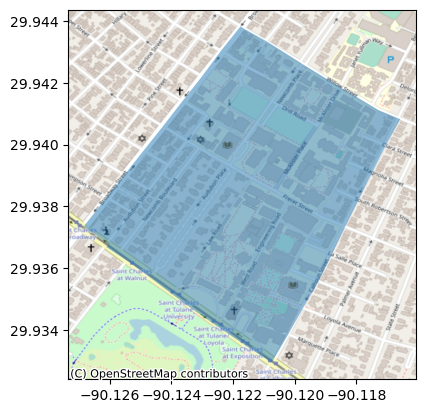

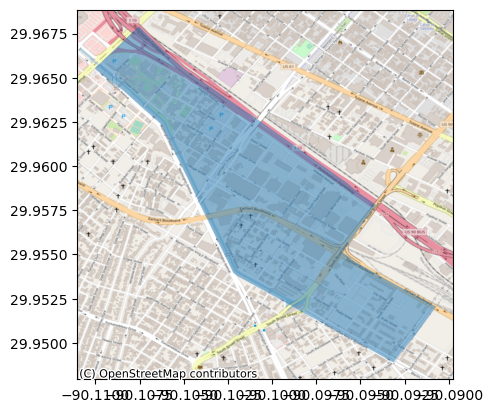

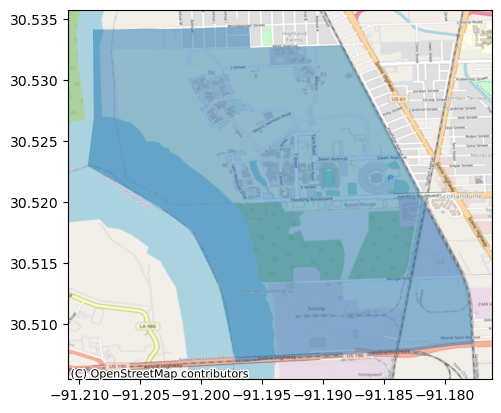

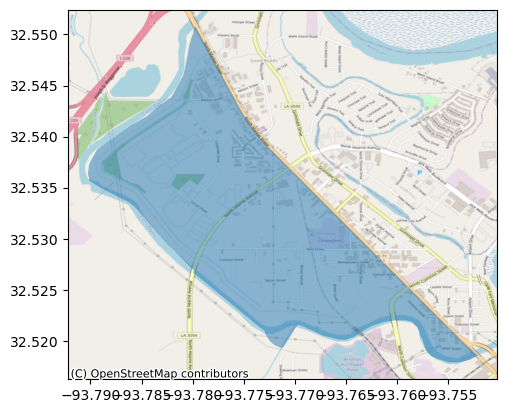

In [46]:
# Tulane University
ax = joined_pber[joined_pber["UNIQUE_ID"]=="Orleans-:-14 13A"].plot(alpha = .5)
cx.add_basemap(ax = ax, crs = filtered_sldu_results.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Xaiver University
ax = joined_pber[joined_pber["UNIQUE_ID"]=="Orleans-:-02 07"].plot(alpha = .5)
cx.add_basemap(ax = ax, crs = filtered_sldu_results.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Louisiana State University
ax = joined_pber[joined_pber["UNIQUE_ID"]=="East Baton Rouge-:-01 100"].plot(alpha = .5)
cx.add_basemap(ax = ax, crs = filtered_sldu_results.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Weird Voter File Things, Jail
ax = joined_pber[joined_pber["UNIQUE_ID"]=="Caddo-:-00 005A"].plot(alpha = .5)
cx.add_basemap(ax = ax, crs = filtered_sldu_results.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

## Notes on this Check

As shown below, it seems like the voter registration data is off in some instances

In [47]:
joined_pber[joined_pber["UNIQUE_ID"].str.contains("Caddo-:-00 005")][["GEOID20","UNIQUE_ID","TOT_VOTES", "REG_TOTAL_", "REG_BLACK_",'REG_TOTA_1']]

,GEOID20,UNIQUE_ID,TOT_VOTES,REG_TOTAL_,REG_BLACK_,REG_TOTA_1
372,2201700005A,Caddo-:-00 005A,96.0,2473,2268,474
373,2201700005B,Caddo-:-00 005B,745.0,141,38,1702


In [48]:
joined_pber[joined_pber["UNIQUE_ID"].str.contains("Pointe Coupee-:-00 13")][["GEOID20","UNIQUE_ID","TOT_VOTES", "REG_TOTAL_", "REG_BLACK_",'REG_TOTA_1']]

,GEOID20,UNIQUE_ID,TOT_VOTES,REG_TOTAL_,REG_BLACK_,REG_TOTA_1
2558,22077000013,Pointe Coupee-:-00 13,625.0,292,93,822
2559,2207713B,Pointe Coupee-:-00 13B,64.0,5,1,77


## Confirm No Election Result Differences Created by Processing

In [49]:
for race in races:
    assert((sum(joined_pber[race]) - sum(election_results_raw[race]))==0)
    

## Final File Cleaning and Export File

In [203]:
if not os.path.exists("./la_gen_2022_prec/la_gen_2022_prec"):
    os.mkdir("./la_gen_2022_prec/la_gen_2022_prec")
    
for col in races:
    joined_pber[col] = joined_pber[col].astype(int)
    
joined_pber = gp.GeoDataFrame(joined_pber[["UNIQUE_ID","COUNTYFP","Parish","Precinct","CONG_DIST","SLDU_DIST"]+races+["geometry"]])

In [206]:
joined_pber["SLDU_DIST"] = joined_pber["SLDU_DIST"].fillna("N/A")

joined_pber["COUNTYFP"] = joined_pber["COUNTYFP"].astype(int).astype(str).str.zfill(3)

In [209]:
joined_pber.to_file("./la_gen_2022_prec/la_gen_2022_prec/la_gen_2022_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
